# Trying Different Configurations for Actor-Critic

In this notebook, we will try out different configurations and plot the performance of the agent vs those configurations.

In [1]:
# import needed libs

%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import matplotlib.pyplot as plt

import datetime

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

In [2]:
# Some initializations

from envs import SmartVac
from agents import ActorCriticAgent

max_episode_steps = 100
results_folder = 'res/'
figs_folder = 'figs/'

In [ ]:
AgentClass = ActorCriticAgent

alpha_base = 2
alpha_pows_w = np.linspace(-6, 0, 4)
alpha_pows_theta = np.linspace(-14, 0, 15)
alphas_w = np.power(alpha_base, alpha_pows_w)
alphas_theta = np.power(alpha_base, alpha_pows_theta)
print(alphas_w)
print(alphas_theta)

best_performance = 0.63
env = SmartVac()
num_of_tests = 5
episode_count = 10000
plot_count = int(episode_count / 100)

agent_name = AgentClass.__name__

results = ""
all_best_avgs = []
all_best_alpha_thetas = []
all_total_avgs = []
all_total_bests = []
all_total_lasts = []
for alpha_pow_w in alpha_pows_w:
    all_avgs = []
    all_bests = []
    all_lasts = []
    alpha_w = np.power(alpha_base, alpha_pow_w)
    for alpha_pow_theta in alpha_pows_theta:
        alpha_theta = np.power(alpha_base, alpha_pow_theta)
        params_str = f'alpha_w_{alpha_w}_alpha_theta_{alpha_theta}_episodes_{episode_count}'
        mult_avgs = []
        for i_test in range(num_of_tests):
            print()
            print(i_test + 1, end=' ')

            # Initialize the agent
            agent = AgentClass(alpha_theta=alpha_theta, alpha_w=alpha_w)

            avgs = []
            probs1 = []
            probs2 = []

            episode_rewards = np.zeros(episode_count)
            for i_episode in range(episode_count):
                done = False
                totalReward = 0

                if i_episode >= plot_count and (i_episode % plot_count == 0):
                    avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                    avgs.append(avg)

                    # deterministic position
                    env.x = 0
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs1.append(prob)

                    # stochastic position
                    env.x = 1
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs2.append(prob)

                    print('#', end='', flush=True)
                    if len(avgs) % 100 == 0:
                        print(i_episode)

                obs = env.reset()
                action = agent.start(obs)

                step = 0
                while not done:
                    obs, reward, done = env.step(action)
                    action = agent.step(obs, reward, done)
                    totalReward += reward

                    step += 1
                    if step > max_episode_steps:
                        done = True

                episode_rewards[i_episode] = totalReward
                agent.update_for_episode()

            mult_avgs.append(avgs)

        avgs = np.mean(np.array(mult_avgs), axis=0)

        all_avgs.append(np.mean(avgs))
        all_bests.append(np.max(avgs))
        all_lasts.append(avgs[-1])

        results_tmp = f'\n\nAgent: {agent_name} \tAlpha_w: {alpha_w}\tAlpha_theta: {alpha_theta}'
        results_tmp += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
        results_tmp += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
        results_tmp += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
        print(results_tmp)

        results += results_tmp
        
    # print best results
    all_avgs = np.array(all_avgs)
    idx = np.argmax(all_avgs)
    all_best_avgs.append(all_avgs[idx])
    all_best_alpha_thetas.append(alphas_theta[idx])
    
    # Save for plotting
    all_total_avgs.append(all_avgs)
    all_total_bests.append(all_bests)
    all_total_lasts.append(all_lasts)
    
# Print best results
all_best_avgs = np.array(all_best_avgs)
idx = np.argmax(all_best_avgs)
results += f'\n\n\nBest Average: {all_best_avgs[idx]}'
results += f'\nConfig: Alpha_w={alphas_w[idx]}, Alpha_theta={all_best_alpha_thetas[idx]}'

print('')
print(results)
# with open(f'{results_folder}agent_{agent_name}_all_mult.txt', 'w') as file:
#     file.write(results)

[0.015625 0.0625   0.25     1.      ]
[6.10351562e-05 1.22070312e-04 2.44140625e-04 4.88281250e-04
 9.76562500e-04 1.95312500e-03 3.90625000e-03 7.81250000e-03
 1.56250000e-02 3.12500000e-02 6.25000000e-02 1.25000000e-01
 2.50000000e-01 5.00000000e-01 1.00000000e+00]

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.015625	Alpha_theta: 6.103515625e-05
Average: 		-0.916
Best 100 Average: 	-0.712
Last 100 Average: 	-0.743

1 ###########################################################################

2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.015625	Alpha_theta: 0.25
Average: 		0.587
Best 100 Average: 	0.657
Last 100 Average: 	0.600

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ####################################################

In [ ]:
plt.figure(2, figsize=(14,10))
plt.semilogx(alphas_theta, np.array(all_total_avgs).T, basex=alpha_base)
plt.title(f'Average Return in {episode_count} episodes')
plt.xlabel('alpha_theta')
plt.ylabel('Average Return')
plt.legend([f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
plt.ylim(best_performance-2.13,best_performance+.07)
# plt.savefig(f'{figs_folder}agent_{agent_name}_episodes_{episode_count}_all_avg.png')

# There is no meaning in bests plot
# plt.figure(3, figsize=(14,10))
# plt.semilogx(alphas_theta, np.array(all_total_bests).T, basex=alpha_base)
# plt.title(f'Best {plot_count}-episode return average until {episode_count} episodes')
# plt.xlabel('alpha')
# plt.ylabel(f'Best {plot_count}-episode average reward')
# plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.legend([f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
# # plt.ylim(best_performance-2.13,best_performance+.07)
# # plt.savefig(f'{figs_folder}agent_{agent_name}_episodes_{episode_count}_all_best.png')

plt.figure(4, figsize=(14,10))
plt.semilogx(alphas_theta, np.array(all_total_lasts).T, basex=alpha_base)
plt.title(f'Last {plot_count}-episode return average')
plt.xlabel('alpha')
plt.ylabel(f'Last {plot_count}-episode average reward')
plt.legend([f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
plt.ylim(best_performance-2.13,best_performance+.07)
# plt.savefig(f'{figs_folder}agent_{agent_name}_episodes_{episode_count}_all_last.png')

plt.show()

# Actor-Critic Configs with other rewards

In [6]:
AgentClass = ActorCriticAgent

alpha_base = 2
alpha_pows_w = np.linspace(-6, 0, 4)
alpha_pows_theta = np.linspace(-14, 0, 15)
alphas_w = np.power(alpha_base, alpha_pows_w)
alphas_theta = np.power(alpha_base, alpha_pows_theta)
print(alphas_w)
print(alphas_theta)

best_performance = -1.37
env = SmartVac(terminal_rewards=(-1,-3))
num_of_tests = 1
episode_count = 10000
plot_count = int(episode_count / 100)

agent_name = AgentClass.__name__

results = ""
all_best_avgs = []
all_best_alpha_thetas = []
all_total_avgs = []
all_total_bests = []
all_total_lasts = []
for alpha_pow_w in alpha_pows_w:
    all_avgs = []
    all_bests = []
    all_lasts = []
    alpha_w = np.power(alpha_base, alpha_pow_w)
    for alpha_pow_theta in alpha_pows_theta:
        alpha_theta = np.power(alpha_base, alpha_pow_theta)
        params_str = f'alpha_w_{alpha_w}_alpha_theta_{alpha_theta}_episodes_{episode_count}'
        mult_avgs = []
        for i_test in range(num_of_tests):
            print()
            print(i_test + 1, end=' ')

            # Initialize the agent
            agent = AgentClass(alpha_theta=alpha_theta, alpha_w=alpha_w)

            avgs = []
            probs1 = []
            probs2 = []

            episode_rewards = np.zeros(episode_count)
            for i_episode in range(episode_count):
                done = False
                totalReward = 0

                if i_episode >= plot_count and (i_episode % plot_count == 0):
                    avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                    avgs.append(avg)

                    # deterministic position
                    env.x = 0
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs1.append(prob)

                    # stochastic position
                    env.x = 1
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs2.append(prob)

                    print('#', end='', flush=True)
                    if len(avgs) % 100 == 0:
                        print(i_episode)

                obs = env.reset()
                action = agent.start(obs)

                step = 0
                while not done:
                    obs, reward, done = env.step(action)
                    action = agent.step(obs, reward, done)
                    totalReward += reward

                    step += 1
                    if step > max_episode_steps:
                        done = True

                episode_rewards[i_episode] = totalReward
                agent.update_for_episode()

            mult_avgs.append(avgs)

        avgs = np.mean(np.array(mult_avgs), axis=0)

        all_avgs.append(np.mean(avgs))
        all_bests.append(np.max(avgs))
        all_lasts.append(avgs[-1])

        results_tmp = f'\n\nAgent: {agent_name} \tAlpha_w: {alpha_w}\tAlpha_theta: {alpha_theta}'
        results_tmp += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
        results_tmp += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
        results_tmp += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
        print(results_tmp)

        results += results_tmp
        
    # print best results
    all_avgs = np.array(all_avgs)
    idx = np.argmax(all_avgs)
    all_best_avgs.append(all_avgs[idx])
    all_best_alpha_thetas.append(alphas_theta[idx])
    
    # Save for plotting
    all_total_avgs.append(all_avgs)
    all_total_bests.append(all_bests)
    all_total_lasts.append(all_lasts)
    
# Print best results
all_best_avgs = np.array(all_best_avgs)
idx = np.argmax(all_best_avgs)
results += f'\n\n\nBest Average: {all_best_avgs[idx]}'
results += f'\nConfig: Alpha_w={alphas_w[idx]}, Alpha_theta={all_best_alpha_thetas[idx]}'

print('')
print(results)
# with open(f'{results_folder}agent_{agent_name}_all_mult.txt', 'w') as file:
#     file.write(results)

[0.015625 0.0625   0.25     1.      ]
[6.10351562e-05 1.22070312e-04 2.44140625e-04 4.88281250e-04
 9.76562500e-04 1.95312500e-03 3.90625000e-03 7.81250000e-03
 1.56250000e-02 3.12500000e-02 6.25000000e-02 1.25000000e-01
 2.50000000e-01 5.00000000e-01 1.00000000e+00]

1 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.015625	Alpha_theta: 6.103515625e-05
Average: 			-2.937
Best 100 Average: 	-2.635
Last 100 Average: 	-2.638

1 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.015625	Alpha_theta: 0.0001220703125
Average: 			-2.857
Best 100 Average: 	-2.474
Last 100 Average: 	-2.724

1 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.015625	Alpha_theta: 0.000244140625
Average: 			-2.718
Best 100 Average: 	-2.277
Last 100 Average: 

1 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.25	Alpha_theta: 0.00048828125
Average: 			-2.535
Best 100 Average: 	-2.134
Last 100 Average: 	-2.160

1 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.25	Alpha_theta: 0.0009765625
Average: 			-2.266
Best 100 Average: 	-1.756
Last 100 Average: 	-1.756

1 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.25	Alpha_theta: 0.001953125
Average: 			-1.993
Best 100 Average: 	-1.548
Last 100 Average: 	-1.646

1 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.25	Alpha_theta: 0.00390625
Average: 			-1.769
Best 100 Average: 	-1.432
Last 100 Average: 	-1.466

1 ########################################

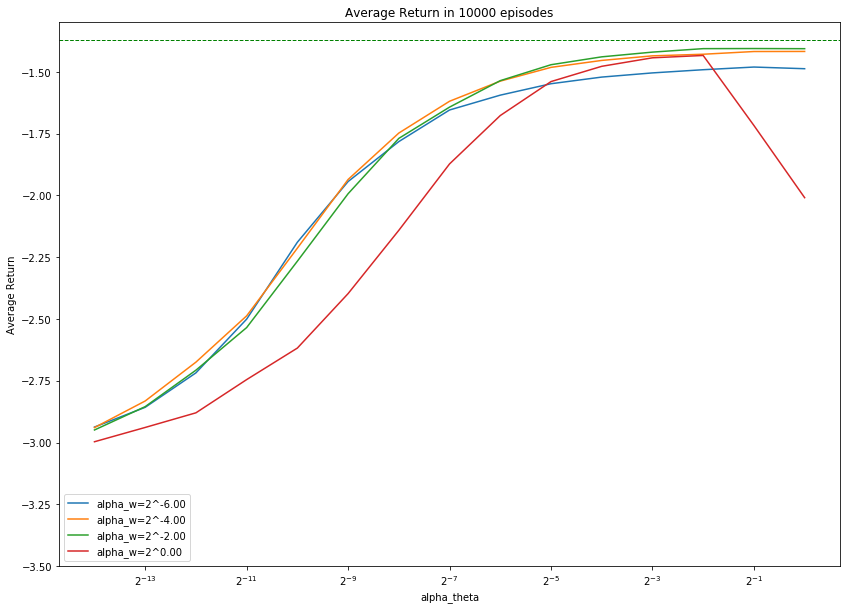

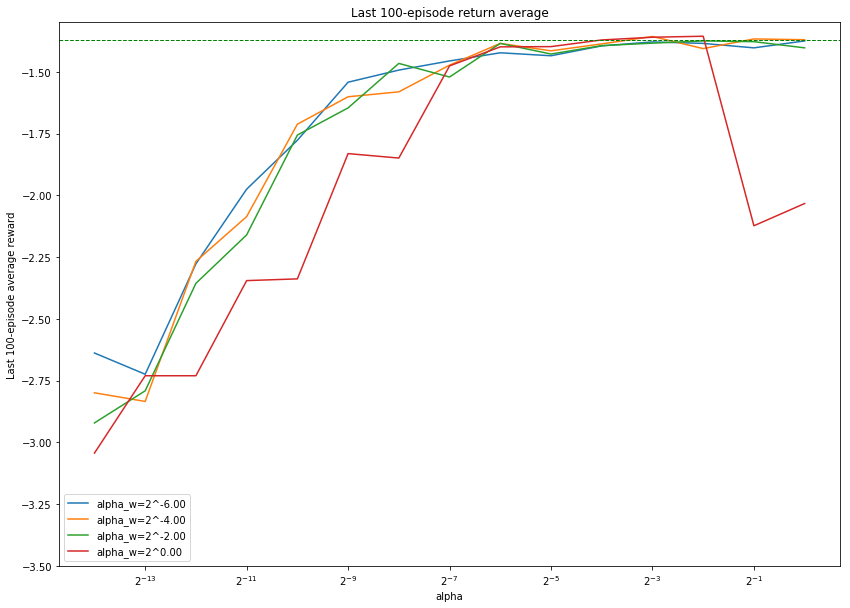

In [7]:
plt.figure(2, figsize=(14,10))
plt.semilogx(alphas_theta, np.array(all_total_avgs).T, basex=alpha_base)
plt.title(f'Average Return in {episode_count} episodes')
plt.xlabel('alpha_theta')
plt.ylabel('Average Return')
plt.legend([f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
plt.ylim(best_performance-2.13,best_performance+.07)
# plt.savefig(f'{figs_folder}agent_{agent_name}_episodes_{episode_count}_all_avg.png')

# There is no meaning in bests plot
# plt.figure(3, figsize=(14,10))
# plt.semilogx(alphas_theta, np.array(all_total_bests).T, basex=alpha_base)
# plt.title(f'Best {plot_count}-episode return average until {episode_count} episodes')
# plt.xlabel('alpha')
# plt.ylabel(f'Best {plot_count}-episode average reward')
# plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.legend([f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
# # plt.ylim(best_performance-2.13,best_performance+.07)
# # plt.savefig(f'{figs_folder}agent_{agent_name}_episodes_{episode_count}_all_best.png')

plt.figure(4, figsize=(14,10))
plt.semilogx(alphas_theta, np.array(all_total_lasts).T, basex=alpha_base)
plt.title(f'Last {plot_count}-episode return average')
plt.xlabel('alpha')
plt.ylabel(f'Last {plot_count}-episode average reward')
plt.legend([f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
plt.ylim(best_performance-2.13,best_performance+.07)
# plt.savefig(f'{figs_folder}agent_{agent_name}_episodes_{episode_count}_all_last.png')

plt.show()